# Backtest

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import penaltyblog as pb

## Get data from football-data.co.uk

In [2]:
df = pd.concat(
    [
        pb.scrapers.FootballData("ENG Premier League", "2019-2020").get_fixtures(),
        pb.scrapers.FootballData("ENG Premier League", "2020-2021").get_fixtures(),
        pb.scrapers.FootballData("ENG Premier League", "2021-2022").get_fixtures(),
    ]
)

df

,date,datetime,season,competition,div,time,team_home,team_away,fthg,ftag,...,b365_cahh,b365_caha,pcahh,pcaha,max_cahh,max_caha,avg_cahh,avg_caha,goals_home,goals_away
id,,,,,,,,,,,,,,,,,,,,,
1565308800---liverpool---norwich,2019-08-09,2019-08-09 20:00:00,2019-2020,ENG Premier League,E0,20:00,Liverpool,Norwich,4,1,...,1.91,1.99,1.94,1.98,1.99,2.07,1.90,1.99,4,1
1565395200---bournemouth---sheffield_united,2019-08-10,2019-08-10 15:00:00,2019-2020,ENG Premier League,E0,15:00,Bournemouth,Sheffield United,1,1,...,1.95,1.95,1.98,1.95,2.00,1.96,1.96,1.92,1,1
1565395200---burnley---southampton,2019-08-10,2019-08-10 15:00:00,2019-2020,ENG Premier League,E0,15:00,Burnley,Southampton,3,0,...,1.87,2.03,1.89,2.03,1.90,2.07,1.86,2.02,3,0
1565395200---crystal_palace---everton,2019-08-10,2019-08-10 15:00:00,2019-2020,ENG Premier League,E0,15:00,Crystal Palace,Everton,0,0,...,1.82,2.08,1.97,1.96,2.03,2.08,1.96,1.93,0,0
1565395200---tottenham---aston_villa,2019-08-10,2019-08-10 17:30:00,2019-2020,ENG Premier League,E0,17:30,Tottenham,Aston Villa,3,1,...,2.10,1.70,2.18,1.77,2.21,1.87,2.08,1.80,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653177600---crystal_palace---man_united,2022-05-22,2022-05-22 16:00:00,2021-2022,ENG Premier League,E0,16:00,Crystal Palace,Man United,1,0,...,1.68,2.15,1.74,2.23,1.88,2.25,1.74,2.16,1,0
1653177600---leicester---southampton,2022-05-22,2022-05-22 16:00:00,2021-2022,ENG Premier League,E0,16:00,Leicester,Southampton,4,1,...,1.83,2.07,1.88,2.03,1.94,2.26,1.87,2.01,4,1
1653177600---liverpool---wolves,2022-05-22,2022-05-22 16:00:00,2021-2022,ENG Premier League,E0,16:00,Liverpool,Wolves,3,1,...,2.02,1.77,2.06,1.83,2.19,1.99,2.07,1.80,3,1


## Create simple logic to make a bet where odds are between 2.5 and 4.0

In [3]:
def logic(ctx):
    fixture = ctx.fixture
    account = ctx.account

    if 2.5 <= fixture["b365_a"] <= 4.0:
        account.place_bet(
            fixture["b365_a"],
            account.current_bankroll * 0.025,
            1 if ctx.fixture["ftr"] == "A" else 0,
        )


backtest = pb.backtest.Backtest(df, "2020-04-01", "2022-06-01", True)
backtest.start(100, logic)
backtest.results()

  0%|          | 0/291 [00:00<?, ?it/s]

{'Total Bets': 260,
 'Successful Bets': 93,
 'Successful Bet %': 35.76923076923077,
 'Max Bankroll': np.float64(297.5066099204424),
 'Min Bankroll': np.float64(99.0982388488196),
 'Profit': 68.73465869630138,
 'ROI': 68.73465869630138}

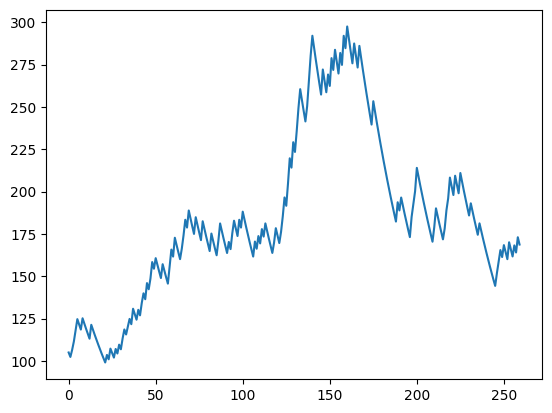

In [4]:
plt.plot(backtest.account.tracker)

## Create logic to train a model and place a bet when kelly criterion is positive

In [5]:
def trainer(ctx):
    weights = pb.models.dixon_coles_weights(ctx.lookback["date"], 0.001)

    model = pb.models.DixonColesGoalModel(
        teams_home=ctx.lookback["team_home"],
        teams_away=ctx.lookback["team_away"],
        goals_home=ctx.lookback["goals_home"],
        goals_away=ctx.lookback["goals_away"],
        weights=weights,
    )

    model.fit()

    return model


def logic(ctx):
    fixture = ctx.fixture
    account = ctx.account
    model = ctx.model

    pred = model.predict(fixture["team_home"], fixture["team_away"])

    kc = pb.kelly.criterion(fixture["b365_h"], pred.home_win, 0.3)
    if kc > 0:
        account.place_bet(
            fixture["b365_h"],
            account.current_bankroll * kc,
            1 if ctx.fixture["ftr"] == "H" else 0,
        )

    kc = pb.kelly.criterion(fixture["b365_a"], pred.away_win, 0.3)
    if kc > 0:
        account.place_bet(
            fixture["b365_a"],
            account.current_bankroll * kc,
            1 if ctx.fixture["ftr"] == "A" else 0,
        )

    kc = pb.kelly.criterion(fixture["b365_d"], pred.draw, 0.3)
    if kc > 0:
        account.place_bet(
            fixture["b365_d"],
            account.current_bankroll * kc,
            1 if ctx.fixture["ftr"] == "D" else 0,
        )

In [6]:
backtest = pb.backtest.Backtest(df, "2022-01-01", "2022-05-01", True)
backtest.start(100, logic, trainer)
backtest.results()

  0%|          | 0/58 [00:00<?, ?it/s]

{'Total Bets': 155,
 'Successful Bets': 54,
 'Successful Bet %': 34.83870967741935,
 'Max Bankroll': np.float64(129.67923829869412),
 'Min Bankroll': np.float64(63.39116281234852),
 'Profit': np.float64(-21.079029724162538),
 'ROI': np.float64(-21.079029724162538)}

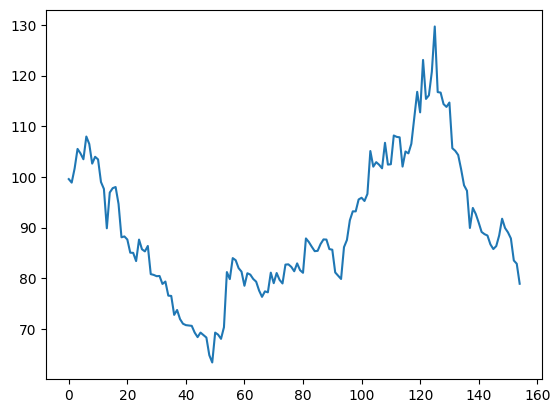

In [7]:
plt.plot(backtest.account.tracker)